<a href="https://colab.research.google.com/github/johanjun/dacon_molit/blob/main/%EC%83%81%EA%B6%8CEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import shutil
import random
import missingno as msno
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/dacon_molit/data/'

### 상권영역
- 좌표계 EPSG: 5181

In [102]:
df_comm = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='euc-kr')

In [15]:
df_comm.shape

(1496, 10)

In [16]:
df_comm.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN


In [ ]:
df_comm['상권_구분_코드_명'].unique()

array(['전통시장', '관광특구', '골목상권', '발달상권'], dtype=object)

In [20]:
#좌표 변환 (ref : https://m.blog.naver.com/wideeyed/221243506770)
from pyproj import Proj, transform
import numpy as np

In [101]:
# Projection 정의
# UTM-K
proj_GRS80 = Proj('epsg:5181') # 중부원점(GRS80) 도로명주소 지도 사용 중

# WGS1984
proj_WGS84 = Proj('epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표

In [103]:
df_comm['엑스좌표_값_2'], df_comm['와이좌표_값_2'] = transform(proj_GRS80, proj_WGS84, df_comm['엑스좌표_값'], df_comm['와이좌표_값'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """Entry point for launching an IPython kernel.


In [98]:
df_comm.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,엑스좌표_값_2,와이좌표_값_2
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN,35.235189,129.657080
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN,35.226340,129.660403
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN,35.310569,129.683101
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN,35.324424,129.673478
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN,35.144122,129.733576


In [99]:
import folium

In [104]:
# 새로운 지도 객체 생성
new_map = folium.Map(location=[37.5642135, 127.0016985], zoom_start=12, tiles='Stamen Toner')

df_mapping = df_comm.sample(10)
# 마커 
for i, m in df_mapping.iterrows():
  marker = folium.Marker(location=[m['엑스좌표_값_2'], m['와이좌표_값_2']],
                         popup=m['상권_코드_명'])
  marker.add_to(new_map)
 
new_map


In [112]:
from fiona.crs import from_string
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString

In [115]:
df_comm['geometry'] = df_comm.apply(lambda row : Point([row['와이좌표_값'], row['엑스좌표_값']]), axis=1)
df_comm = gpd.GeoDataFrame(df_comm, geometry='geometry')

In [116]:
df_comm.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,엑스좌표_값_2,와이좌표_값_2,geometry
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN,35.232408,129.659085,POINT (442084.000 196121.000)
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN,35.223559,129.662409,POINT (442413.000 195147.000)
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN,35.307789,129.685107,POINT (444227.000 204551.000)
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN,35.321644,129.675484,POINT (443310.000 206065.000)
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN,35.141341,129.735578,POINT (449328.000 186203.000)


In [117]:
epsg5181 = from_string("+proj=tmerc +lat_0=38 +lon_0=127 +k=1 +x_0=200000 +y_0=500000 +ellps=GRS80 +units=m +no_defs")

In [118]:
print(df_comm.crs)

None


In [119]:
df_comm.crs = epsg5181
print(df_comm.crs)

+proj=tmerc +lat_0=38 +lon_0=127 +k=1 +x_0=200000 +y_0=500000 +ellps=GRS80 +units=m +no_defs +type=crs


In [120]:
epsg4326 = from_string("proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [121]:
df_comm = df_comm.to_crs(epsg4326)

In [123]:
df_comm.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,엑스좌표_값_2,와이좌표_값_2,geometry
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN,35.232408,129.659085,POINT (129.65909 35.23241)
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN,35.223559,129.662409,POINT (129.66241 35.22356)
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN,35.307789,129.685107,POINT (129.68511 35.30779)
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN,35.321644,129.675484,POINT (129.67548 35.32164)
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN,35.141341,129.735578,POINT (129.73558 35.14134)


In [125]:
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_comm.geometry ]

In [136]:
df_mapping['상권_코드_명'].iloc[0]

'독산로78다길'

In [184]:
# 새로운 지도 객체 생성
new_map = folium.Map(location=[37.5642135, 127.0016985], zoom_start=12, tiles='Stamen Toner')

df_mapping = df_comm.sample(10)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_mapping.geometry ]
# 마커
i = 0
for g in geo_df_list:
  marker = folium.Marker(location=g,
                         popup=df_mapping['상권_코드_명'].iloc[i])
  marker.add_to(new_map)
  i += 1
 
new_map


In [142]:
df_mapping

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,엑스좌표_값_2,와이좌표_값_2,geometry
1199,201810,D,발달상권,1001187,한양시장,203544,451149,11200,11200550,NaN,35.297010,129.760823,POINT (129.76082 35.29701)
90,201810,A,골목상권,1000316,노해로23길,201908,460563,11305,11305620,NaN,35.279877,129.863677,POINT (129.86368 35.27988)
319,201810,A,골목상권,1000904,도곡로37길,203820,443975,11680,11680650,NaN,35.301269,129.682121,POINT (129.68212 35.30127)
1183,201810,A,골목상권,1000271,동소문로2길,200805,454405,11290,11290555,NaN,35.271529,129.795730,POINT (129.79573 35.27153)
801,201810,A,골목상권,1000419,응암로14길,192904,454501,11380,11380600,NaN,35.200375,129.794341,POINT (129.79434 35.20037)
152,201810,A,골목상권,1000227,답십리로75길,207204,452767,11260,11260540,NaN,35.329553,129.779719,POINT (129.77972 35.32955)
1071,201810,R,전통시장,1001399,경창시장,186077,447263,11470,11470570,NaN,35.140715,129.712907,POINT (129.71291 35.14072)
455,201810,A,골목상권,1000344,인수봉로72길,201136,460373,11305,11305660,NaN,35.272976,129.861347,POINT (129.86135 35.27298)
1417,201810,A,골목상권,1000297,정릉로26길,201022,456027,11290,11290630,NaN,35.273070,129.813603,POINT (129.81360 35.27307)
280,201810,A,골목상권,1000594,양천로26길,184315,452508,11500,11500630,NaN,35.123550,129.769857,POINT (129.76986 35.12355)


In [153]:
print(37.587918798213394 - df_mapping.loc[1183]['엑스좌표_값_2'])
print(127.00815960377855 - df_mapping.loc[1183]['와이좌표_값_2'])

2.3163893420225747
-2.7875701162649875


In [154]:
print(37.52474449758431 - df_mapping.loc[1071]['엑스좌표_값_2'])
print(126.8423897012334 - df_mapping.loc[1071]['와이좌표_값_2'])

2.384029025552806
-2.870517016042726


In [179]:
del df_comm['엑스좌표_값_보정']
del df_comm['와이좌표_값_보정']

In [180]:
df_comm['엑스좌표_값_보정'] = df_comm['엑스좌표_값_2'] + 2.25
df_comm['와이좌표_값_보정'] = df_comm['와이좌표_값_2'] - 2.75

In [181]:
df_comm['geometry_보정'] = df_comm.apply(lambda row : Point([row['와이좌표_값_보정'], row['엑스좌표_값_보정']]), axis=1)
df_comm = gpd.GeoDataFrame(df_comm, geometry='geometry_보정')

In [182]:
df_comm.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,엑스좌표_값_2,와이좌표_값_2,geometry,geometry_보정,엑스좌표_값_보정,와이좌표_값_보정
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN,35.232408,129.659085,POINT (129.65909 35.23241),POINT (126.90909 37.48241),37.482408,126.909085
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN,35.223559,129.662409,POINT (129.66241 35.22356),POINT (126.91241 37.47356),37.473559,126.912409
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN,35.307789,129.685107,POINT (129.68511 35.30779),POINT (126.93511 37.55779),37.557789,126.935107
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN,35.321644,129.675484,POINT (129.67548 35.32164),POINT (126.92548 37.57164),37.571644,126.925484
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN,35.141341,129.735578,POINT (129.73558 35.14134),POINT (126.98558 37.39134),37.391341,126.985578


In [183]:
from folium import plugins
new_map = folium.Map(location=[37.5642135, 127.0016985], zoom_start=12, tiles='Cartodb dark_matter')

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in df_comm['geometry_보정']]
plugins.HeatMap(heat_data).add_to(new_map)
 
new_map


### 상권 매출정보

In [ ]:
df_comm2021 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding='euc-kr')
df_comm2020 = pd.read_csv(data_dir+'서울시우리마을가게상권분석서비스(상권-추정매출)_2020.csv', encoding='euc-kr')
df_comm2019 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding='euc-kr')
df_comm2018 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding='euc-kr')
df_comm2017 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding='euc-kr')
df_comm2016 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding='euc-kr')
df_comm2015 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding='euc-kr')
df_comm2014 = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_2014.csv', encoding='euc-kr')

In [ ]:
df_comm_merge = pd.concat([df_comm2021,
                           df_comm2020,
                           df_comm2019,
                           df_comm2018,
                           df_comm2017,
                           df_comm2016,
                           df_comm2015,
                           df_comm2014], axis=0)

In [ ]:
df_comm_merge.shape

(1123363, 80)

In [ ]:
df_comm_merge.drop_duplicates(inplace=True)

In [ ]:
#중복 없음
df_comm_merge.shape

(1123363, 80)

In [ ]:
df_comm_merge.to_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-추정매출)_merged.csv')

In [ ]:
df_comm_merge.head(3)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,주중_매출_건수,주말_매출_건수,월요일_매출_건수,화요일_매출_건수,수요일_매출_건수,목요일_매출_건수,금요일_매출_건수,토요일_매출_건수,일요일_매출_건수,시간대_건수~06_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2021,1,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,5.246740e+05,5,0,100,0,0,0,0,0,0,100,0,0,0,100,0,0,0,100,0,0,100,0,0,0,0.000000e+00,5.246740e+05,0,0.0,0,0,0,0,524674,0,0,0.000000e+00,5.246740e+05,0.000000e+00,0,0.000000e+00,5.246740e+05,0,0,524674,0.000000e+00,0,0,0,5,0,0,0,0,0,0,5,0,0,0,5,0,0,0,5,0,0,5,0,0,0,8
1,2021,1,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,2.403139e+09,8727,65,35,11,9,14,11,20,18,17,0,1,23,37,37,1,41,42,1,16,21,15,18,13,1.563560e+09,8.395794e+08,265612914,221972354.0,334096984,252903344,488973948,435773386,403806022,0,31855170,5.553222e+08,8.959576e+08,8.913677e+08,28636279,9.957871e+08,9.988147e+08,12325728,385280809,506686589,3.553265e+08,427986666,306995464,5636,3091,1181,888,1309,976,1282,1527,1564,0,108,1982,2903,3656,78,3692,4386,120,2034,2064,1728,1333,797,8
2,2021,1,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,1.176752e+10,6378,52,48,11,7,8,17,8,24,24,0,3,32,42,24,0,43,57,0,2,12,35,22,29,6.094250e+09,5.673275e+09,1312540310,847128724.0,934787562,2052697510,947095978,2861453898,2811820821,0,332519888,3.758998e+09,4.901461e+09,2.774545e+09,0,5.051799e+09,6.715726e+09,0,262788962,1405527456,4.092103e+09,2626606523,3380499293,3490,2888,700,796,604,854,536,1359,1529,0,215,1978,2525,1660,0,2528,3850,0,296,768,1771,1547,1996,6


In [ ]:
df_comm_merge.info()

In [ ]:
len(df_comm_merge['상권_코드_명'].unique())

1496

### 점포 현황

In [ ]:
df_jumpo = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권배후지-점포).csv', encoding='euc-kr')
df_jumpo.shape

(454122, 15)

In [ ]:
df_jumpo.head(3)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
0,2021,1,A,골목상권,1001010,풍성로37가길,CS300043,전자상거래업,35,35,0,0,0,0,0
1,2021,1,A,골목상권,1001010,풍성로37가길,CS300042,주유소,2,2,0,0,0,0,0
2,2021,1,A,골목상권,1001010,풍성로37가길,CS300041,예술품,1,1,0,0,0,0,0


In [ ]:
len(df_jumpo['상권_코드'].unique())

1010

In [ ]:
df_jumpo['기준_년_코드'].unique()

array([2021, 2020])

In [ ]:
df_jumpo.groupby(['상권_코드','서비스_업종_코드_명']).sum()

기준_년_코드  기준_분기_코드  점포_수  ...  폐업_률  폐업_점포_수  프랜차이즈_점포_수
상권_코드   서비스_업종_코드_명                           ...                           
1000001 PC방            10101        11     0  ...     0        0           0
        가구             10101        11    14  ...     0        0           0
        가방             10101        11    27  ...    20        1           0
        가전제품           10101        11     5  ...     0        0           0
        가전제품수리         10101        11     5  ...     0        0           0
...                      ...       ...   ...  ...   ...      ...         ...
1001010 핸드폰            10101        11    41  ...    27        2           0
        호프-간이주점        10101        11   198  ...    14        7          49
        화장품            10101        11    77  ...     6        1           5
        화초             10101        11    57  ...    27        3           0
        회계사사무소         10101        11     0  ...     0        0           0

[91051 rows x 9 columns]

### 집객시설
- 집객시설이란? 사전적 의미 그대로 고객을 유입시키는 흡입력을 지닌 시설이라 할 수 있습니다. 대표적으로 영화관, 할인점, 병원, 백화점 등이 될 수 있겠습니다.

In [6]:
df_jip = pd.read_csv(data_dir+'서울시 우리마을가게 상권분석서비스(상권-집객시설).csv', encoding='euc-kr')
df_jip.shape

(35880, 26)

In [7]:
df_jip.head(3)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수
0,2021,1,A,골목상권,1000231,동일로123길,19,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0
1,2021,1,A,골목상권,1000467,동교로19길,17,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,6.0
2,2021,1,A,골목상권,1000813,서림7길,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,3.0


In [8]:
len(df_jip['상권_코드'].unique())

1474

In [9]:
df_jip['기준_년_코드'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016, 2015])

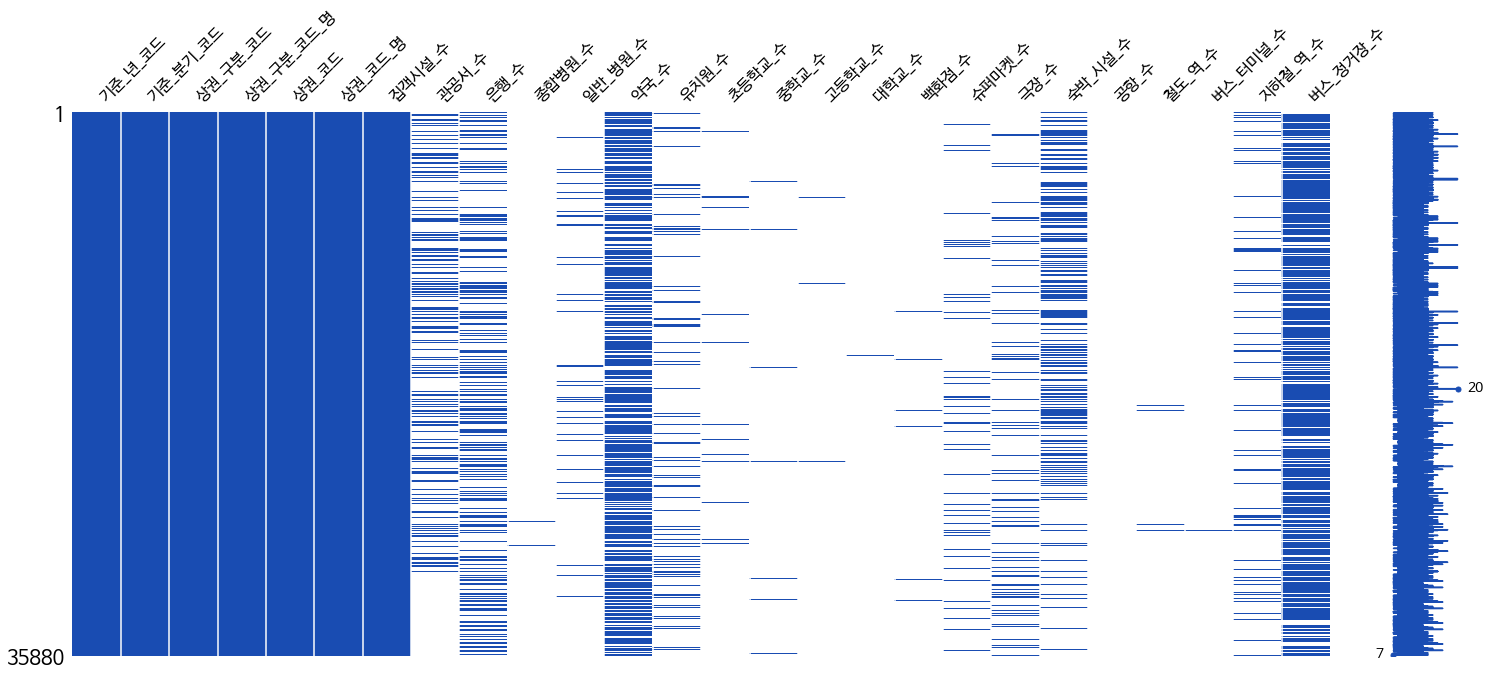

In [12]:
msno.matrix(df_jip, color=(0.1, 0.3, 0.7))

In [13]:
df_jip['상권_코드_명'].unique()

array(['동일로123길', '동교로19길', '서림7길', ..., '답십리현대시장', '강남시장_동작', '능동로골목시장'],
      dtype=object)